# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# #setting for colab

# from google.colab import drive
# drive.mount('/content/drive')

# try:
#     import pickle5 as pickle
# except:
#     !pip install pickle5
#     import pickle5 as pickle

# try:
#     import lightgbm as lgb
# except:
#     !pip install lightgbm
#     import lightgbm as lgb

In [2]:
# setting for jupyter notebook

import pickle
import lightgbm as lgb

In [3]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
# path = '/content/drive/MyDrive/black_swan_physionet/'

file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [4]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
# print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [5]:
# scaler를 이용한 정규화

# import pickle5 as pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

# print(X_train.shape)
# print(y_train.shape)
# X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
# print(X_train_3d.shape)
# y_train_3d = y_train[::maxlen]
# print(y_train_3d.shape)

# X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
# print(X_valid_3d.shape)
# y_valid_3d = y_valid[::maxlen]
# print(y_valid_3d.shape)

# X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
# print(X_test_3d.shape)
# y_test_3d = y_test[::maxlen]
# print(y_test_3d.shape)

# Model 설계 

## lightBGM

In [6]:
from sklearn.metrics import roc_auc_score

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary', metric=['auc'])
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.5261099532651257

In [7]:
# GridSearchCV를 위해 train data와 valid data를 합침.
X_train.shape
y_train.shape
X_valid.shape
y_valid.shape

X = np.concatenate((X_train, X_valid), axis=0)
X.shape
y = np.concatenate((y_train, y_valid), axis=0)
y.shape


(252000,)

In [8]:
lgb_clf = lgb.LGBMClassifier(n_estimatators = 400)
evals = (X_valid, y_valid)
model = lgb_clf.fit(X_train, y_train, early_stopping_rounds=10, 
            eval_metric='auc', eval_set = evals, verbose=True)
pred = model.predict(X_test)
print('-'*50)
print(roc_auc_score(y_test, pred))


[LightGBM] [Warning] Unknown parameter: n_estimatators
[1]	valid_0's auc: 0.734189	valid_0's binary_logloss: 0.387934
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.776443	valid_0's binary_logloss: 0.378017
[3]	valid_0's auc: 0.782113	valid_0's binary_logloss: 0.37065
[4]	valid_0's auc: 0.792328	valid_0's binary_logloss: 0.364819
[5]	valid_0's auc: 0.791644	valid_0's binary_logloss: 0.360515
[6]	valid_0's auc: 0.793898	valid_0's binary_logloss: 0.355684
[7]	valid_0's auc: 0.797003	valid_0's binary_logloss: 0.35229
[8]	valid_0's auc: 0.793129	valid_0's binary_logloss: 0.350796
[9]	valid_0's auc: 0.78999	valid_0's binary_logloss: 0.349265
[10]	valid_0's auc: 0.786707	valid_0's binary_logloss: 0.34784
[11]	valid_0's auc: 0.78408	valid_0's binary_logloss: 0.347314
[12]	valid_0's auc: 0.783973	valid_0's binary_logloss: 0.346507
[13]	valid_0's auc: 0.779684	valid_0's binary_logloss: 0.34694
[14]	valid_0's auc: 0.782906	valid_0's binary_logloss: 0.345128
[15

[LightGBM] [Info] Number of positive: 29890, number of negative: 196910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4893
[LightGBM] [Info] Number of data points in the train set: 226800, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131790 -> initscore=-1.885223
[LightGBM] [Info] Start training from score -1.885223
[1]	valid_0's auc: 0.734189	valid_0's binary_logloss: 0.387934
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.776443	valid_0's binary_logloss: 0.378017
[3]	valid_0's auc: 0.782113	valid_0's binary_logloss: 0.37065
[4]	valid_0's auc: 0.792328	valid_0's binary_logloss: 0.364819
[5]	valid_0's auc: 0.791644	valid_0's binary_logloss: 0.360515
[6]	valid_0's auc: 0.793898	valid_0's binary_logloss: 0.355684


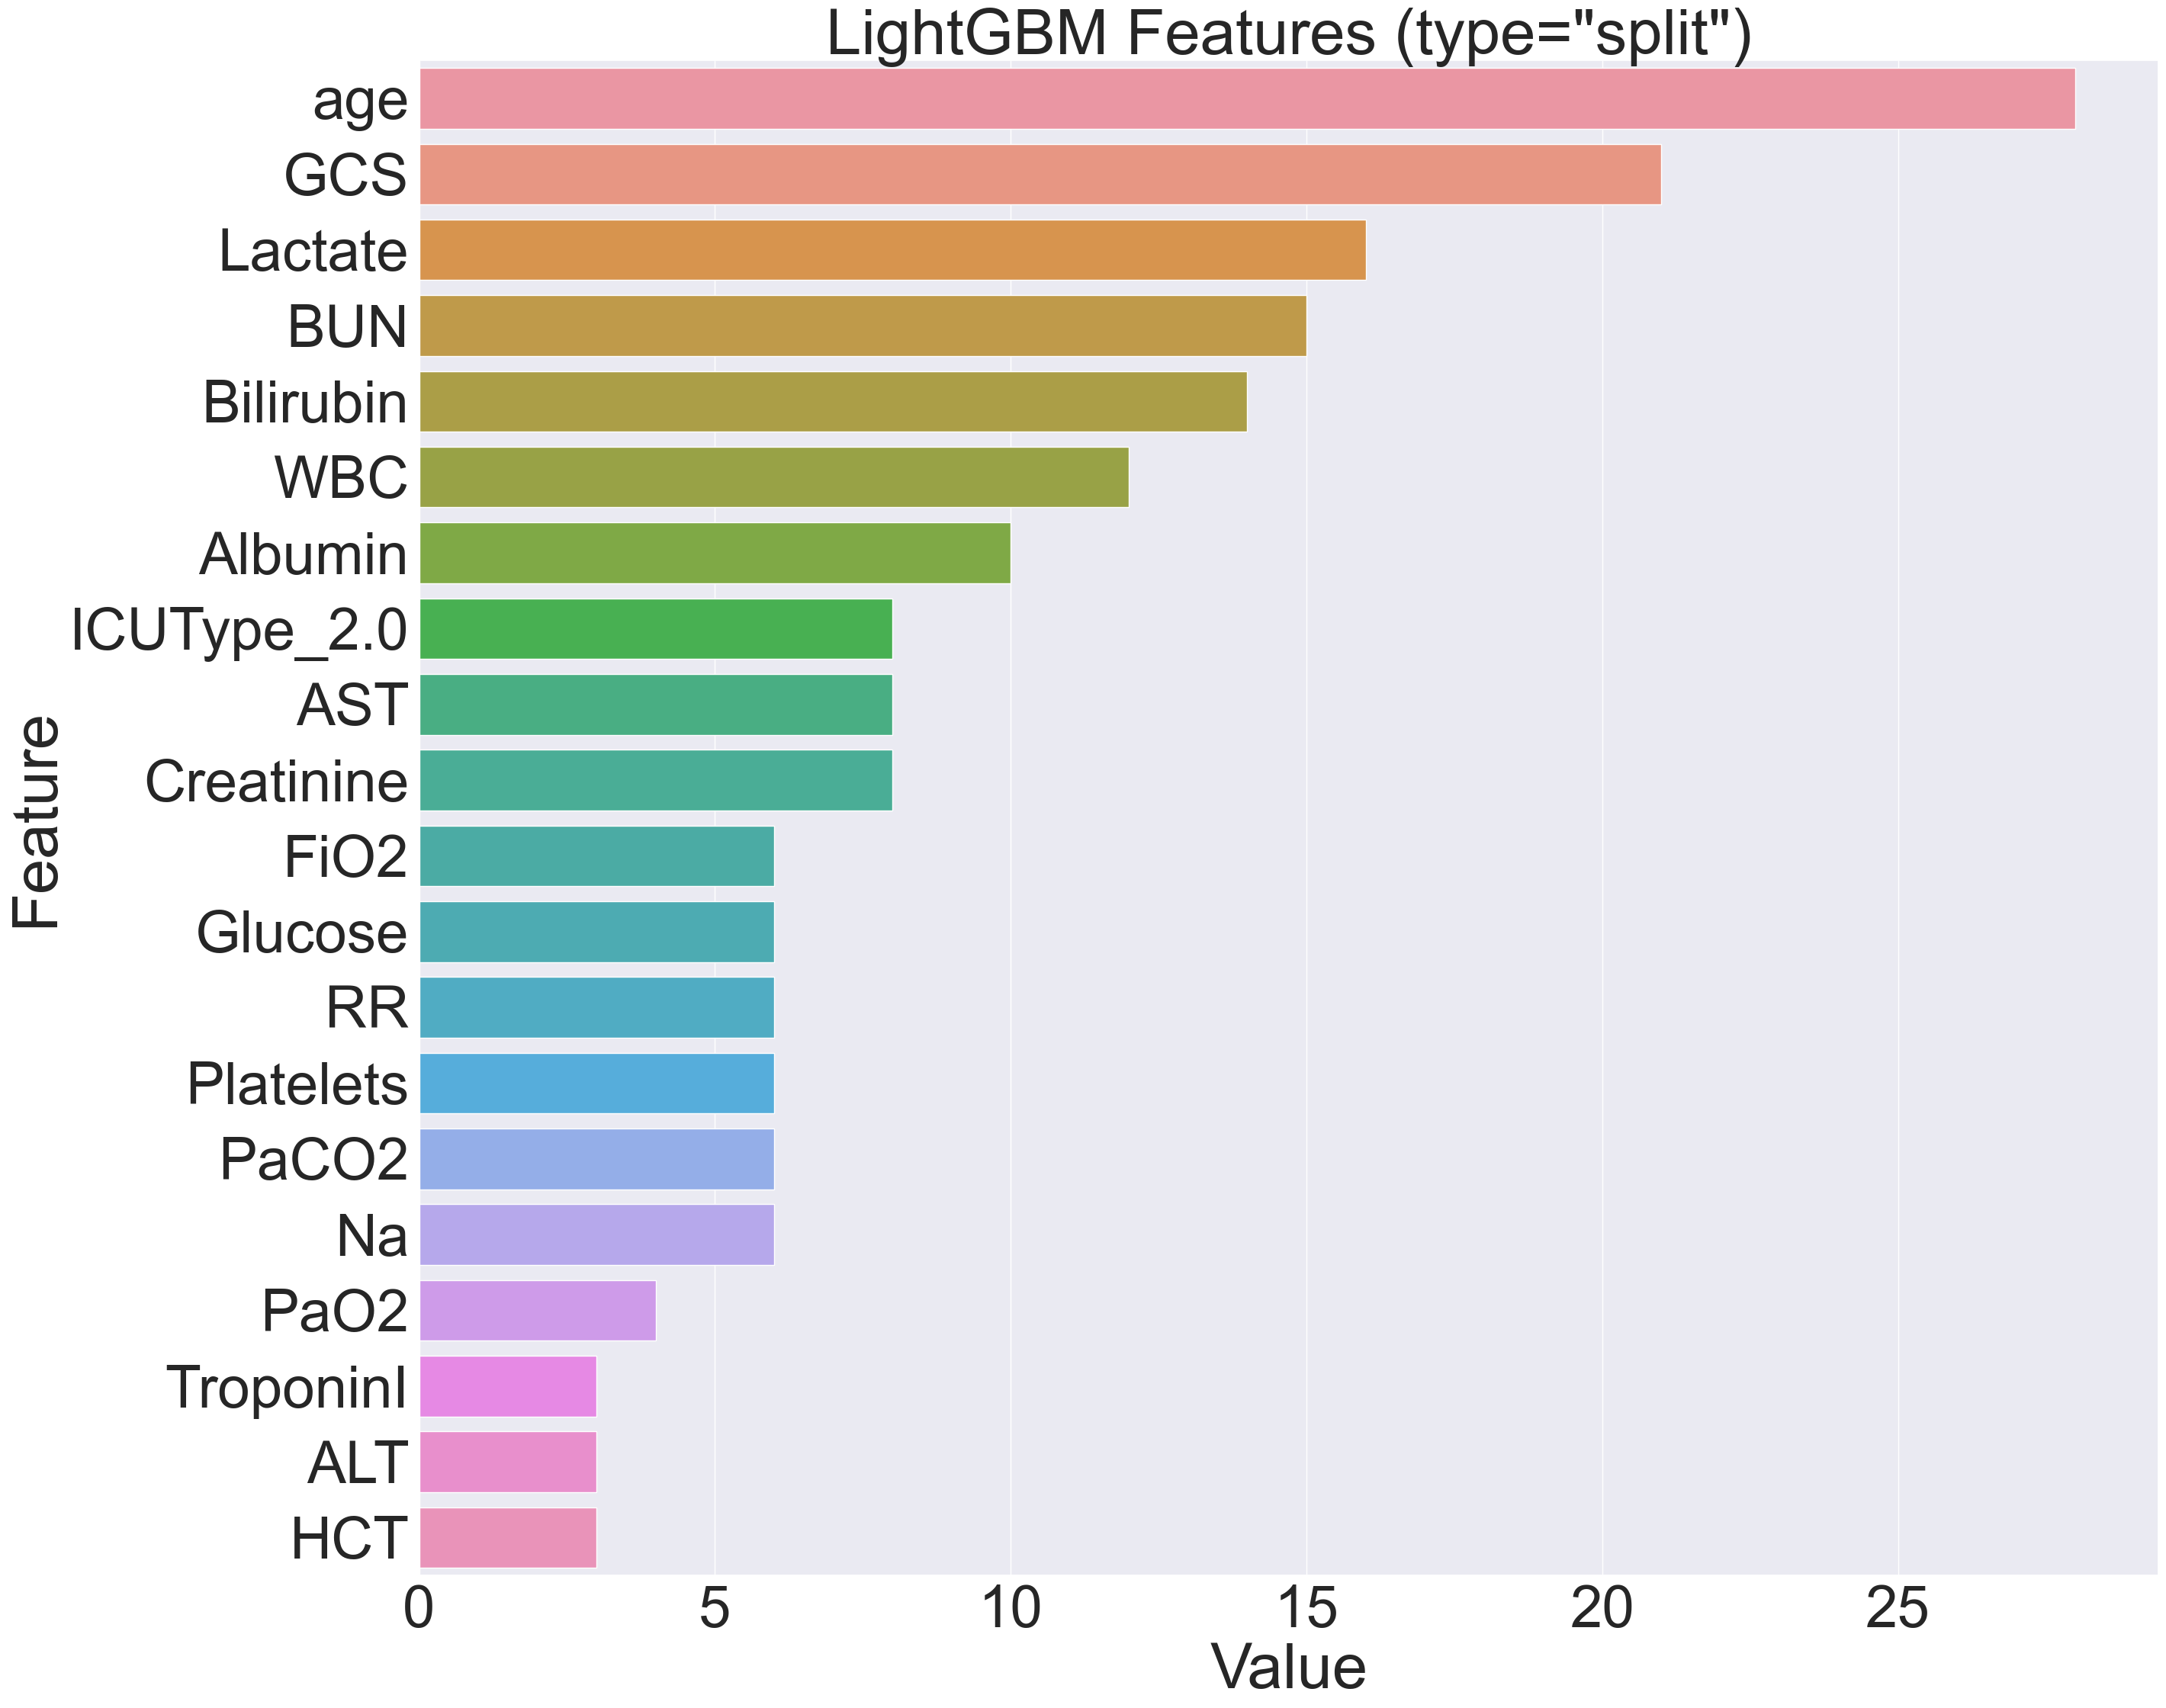

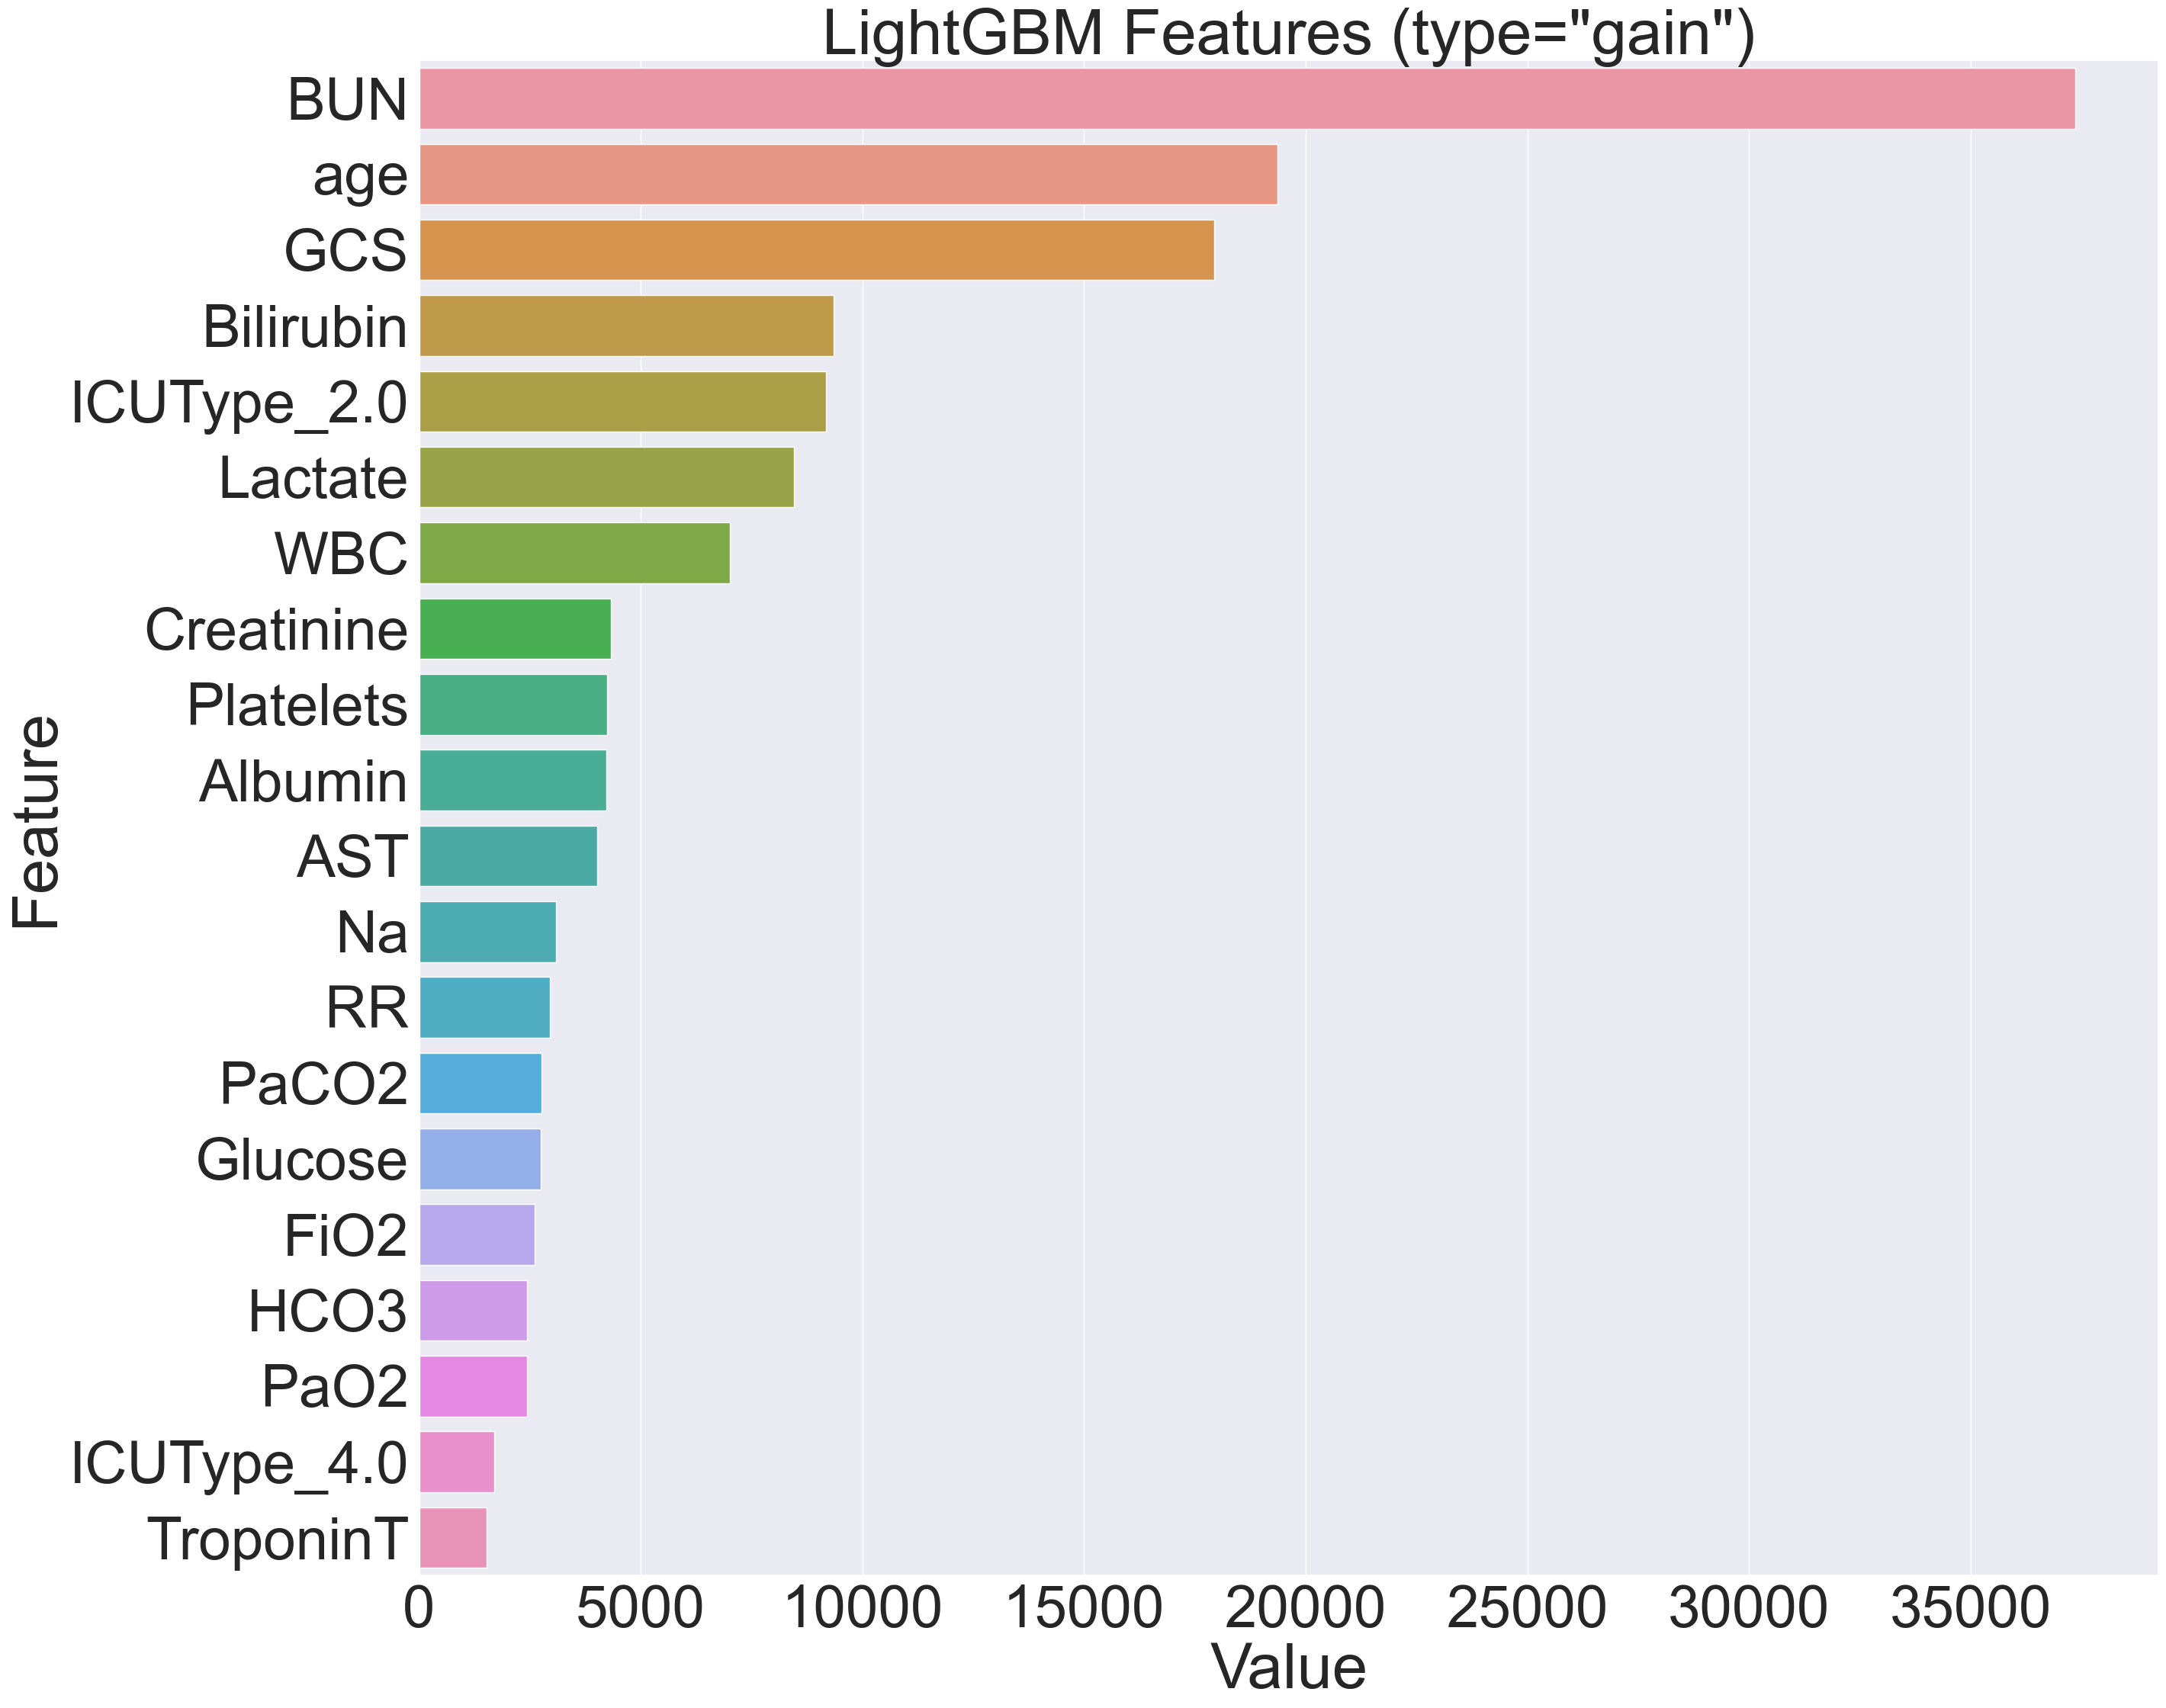

[[28 'age']
 [21 'GCS']
 [16 'Lactate']
 [15 'BUN']
 [14 'Bilirubin']
 [12 'WBC']
 [10 'Albumin']
 [8 'ICUType_2.0']
 [8 'AST']
 [8 'Creatinine']
 [6 'FiO2']
 [6 'Glucose']
 [6 'RR']
 [6 'Platelets']
 [6 'PaCO2']
 [6 'Na']
 [4 'PaO2']
 [3 'TroponinI']
 [3 'ALT']
 [3 'HCT']]
[[37364.61019897461 'BUN']
 [19356.989044189453 'age']
 [17934.284088134766 'GCS']
 [9352.536102294922 'Bilirubin']
 [9178.555084228516 'ICUType_2.0']
 [8457.495971679688 'Lactate']
 [7019.001037597656 'WBC']
 [4321.959991455078 'Creatinine']
 [4244.592956542969 'Platelets']
 [4222.165023803711 'Albumin']
 [4008.666015625 'AST']
 [3092.9969787597656 'Na']
 [2946.2340698242188 'RR']
 [2763.89306640625 'PaCO2']
 [2751.2539978027344 'Glucose']
 [2599.3699951171875 'FiO2']
 [2435.0059509277344 'HCO3']
 [2429.071044921875 'PaO2']
 [1692.9450378417969 'ICUType_4.0']
 [1526.0809631347656 'TroponinT']]
length of X_test_nonorm.columns:  40
length of bst.feature_importance:  40


In [11]:
# lgb.train 메소드 사용하기 - early_stopping, model_save, best_iteration 제공.
import matplotlib.pyplot as plt
import seaborn as sns

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss']

num_round = 400
bst = lgb.train(param, train_data, num_round, valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

pred = bst.predict(X_test, num_iteration=bst.best_iteration)
bst.save_model(path+'lgb_model_best_upto_machine.txt', num_iteration=bst.best_iteration)
# loaded_model = lgb.Booster(model_file=path+'lgb_model_best_upto_machine.txt')
print('roc_auc_score of test: ', roc_auc_score(y_test, pred))

num=20
fig_size=(30,24)

# importance_type='split'
feat_import_split = dict(ll for ll in zip(np.array(X_test_nonorm.columns), bst.feature_importance(importance_type='split')))
feature_imp_split = pd.DataFrame({'Value':feat_import_split.values(),'Feature':feat_import_split.keys()})
plt.figure(figsize=fig_size)
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", 
                                                    ascending=False)[0:num])
plt.title('LightGBM Features (type="split")')
plt.tight_layout()
plt.savefig(path+'lgbm_importances_spit.png')
plt.show()

# importance_type='gain'
feat_import_gain = dict(ll for ll in zip(np.array(X_test_nonorm.columns), bst.feature_importance(importance_type='gain')))
feature_imp_gain = pd.DataFrame({'Value':feat_import_gain.values(),'Feature':feat_import_gain.keys()})
plt.figure(figsize=fig_size)
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp_gain.sort_values(by="Value", 
                                                    ascending=False)[0:num])
plt.title('LightGBM Features (type="gain")')
plt.tight_layout()
plt.savefig(path+'lgbm_importances_gain.png')
plt.show()

print(feature_imp_split.sort_values(by='Value', ascending=False)[0:num].to_numpy())
print(feature_imp_gain.sort_values(by='Value', ascending=False)[0:num].to_numpy())

print('length of X_test_nonorm.columns: ', len(X_test_nonorm.columns))
print('length of bst.feature_importance: ', len(bst.feature_importance()))

In [11]:
# colab gpu 설정

!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!pip install --upgrade pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 27953, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 27953 (delta 4), reused 17 (delta 3), pack-reused 27921
Receiving objects: 100% (27953/27953), 19.74 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (20695/20695), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing

In [12]:
from sklearn.model_selection import GridSearchCV
import time
import lightgbm as lgb
import pickle

start = time.time()

lgbm = lgb.LGBMClassifier(n_estimators = 400) #Define the parameters
parameters = {'num_leaves':[31, 100, 200, 300], 'max_depth':[15,20,25], 'objective':['binary'],
             'learning_rate':[0.001,0.005,0.01],'min_data_in_leaf':[20, 100, 300, 500]}#Define the scoring
clf=GridSearchCV(lgbm, parameters, scoring='roc_auc', 
                 cv=3, verbose=True)
clf.fit(X, y) # train data와 valid data를 합침.
print(clf.best_params_)
predicted=clf.best_estimator_.predict(X_test)
print('Classification of the result is:')
print(roc_auc_score(y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)



Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'learning_rate': 0.01, 'max_depth': 20, 'min_data_in_leaf': 500, 'num_leaves': 31, 'objective': 'binary'}
Classification of the result is:
0.5072044334975369
Execution time is:
5959.692758798599


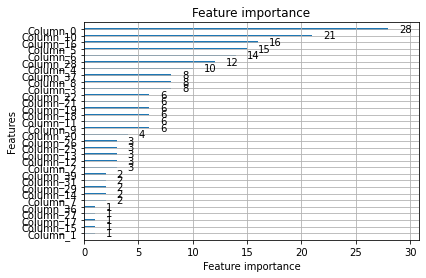

In [ ]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgb_clf)

In [ ]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70, 128)           5248      
                                                                 
 dropout (Dropout)           (None, 70, 128)           0         
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                573504    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                1170      
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [ ]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'chp_simple_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

cnn_history = simple_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 6s 18ms/step - loss: 0.3789 - acc: 0.8673 - auc: 0.6553 - val_loss: 0.3226 - val_acc: 0.8639 - val_auc: 0.8151
Epoch 2/20
81/81 [==============================] - 0s 4ms/step - loss: 0.3448 - acc: 0.8682 - auc: 0.7466 - val_loss: 0.3402 - val_acc: 0.8639 - val_auc: 0.8165
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 0.3264 - acc: 0.8682 - auc: 0.7834 - val_loss: 0.3199 - val_acc: 0.8639 - val_auc: 0.8254
Epoch 4/20
81/81 [==============================] - 0s 4ms/step - loss: 0.3261 - acc: 0.8704 - auc: 0.7859 - val_loss: 0.3166 - val_acc: 0.8778 - val_auc: 0.8336
Epoch 5/20
81/81 [==============================] - 0s 4ms/step - loss: 0.3211 - acc: 0.8722 - auc: 0.7959 - val_loss: 0.3174 - val_acc: 0.8722 - val_auc: 0.8257
Epoch 6/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3147 - acc: 0.8722 - auc: 0.8065 - val_loss: 0.3260 - val_acc: 0.8611 - val_auc: 0.8105
Epoch 7/20
81/81 [=========

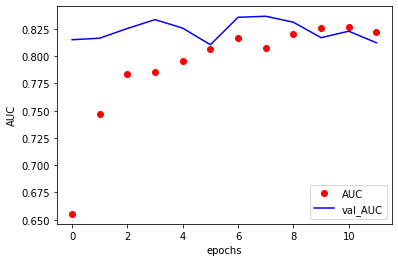

In [ ]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = simple_model.history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

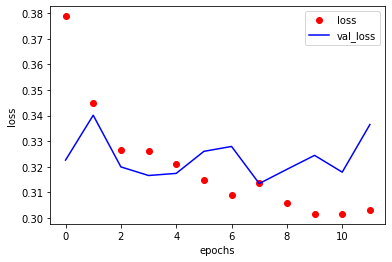

In [ ]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# test loss, acc, auc 구하기1
test_loss, test_acc, test_auc = simple_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')


# auroc 구하기2
from sklearn.metrics import roc_auc_score

test_pred = simple_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 3ms/step - loss: 0.3095 - acc: 0.8750 - auc: 0.8282
test_acc: 0.8750
test_auc: 0.8282
13/13 [==============================] - 0s 2ms/step
acc_test: 0.8750
auc_score_test: 0.8282


In [ ]:
simple_model.save(path+'simple_model_best_upto.h5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score

# model_name
# 'simple_model_best_upto.h5'
loaded_model = load_model(path+model_name)

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 2ms/step
acc_test: 0.8750
auc_score_test: 0.8066


### 어떻게 checkpoint 건 결과가 더 안좋게 나오지??

In [ ]:
y_test_3d

0        0.0
70       0.0
140      0.0
210      0.0
280      0.0
        ... 
27650    0.0
27720    0.0
27790    1.0
27860    0.0
27930    0.0
Name: labels, Length: 400, dtype: float64

In [ ]:
test_df.drop_duplicates(['pid'])

,pid,age,Gender,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,...,MBP,male,female,surv_los,LOS,labels,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0
0,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0
70,142245.0,86.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-8.0,7.0,0.0,0,1,0,0
140,137989.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,541.0,47.0,0.0,0,0,1,0
210,142184.0,74.0,0.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,...,77.0,1.0,0.0,-38.0,37.0,0.0,0,0,0,1
280,134318.0,48.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-15.0,14.0,0.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27650,139907.0,39.0,0.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,...,77.0,1.0,0.0,-85.0,84.0,0.0,0,0,0,1
27720,136230.0,75.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-10.0,9.0,0.0,1,0,0,0
27790,139358.0,71.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,...,77.0,1.0,0.0,-2.0,28.0,1.0,0,0,0,1
27860,137755.0,81.0,0.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,...,77.0,1.0,0.0,59.0,14.0,0.0,0,1,0,0


In [ ]:
print(test_df.shape)
print(X_test_3d.shape)

(28000, 46)
(400, 70, 40)


In [ ]:
test_df['cnn_pred_30'] = 0.0
test_df['label'] = y_test
for i, pid in enumerate(list(test_df.pid.unique())):
    test_df.loc[test_df.query('pid==@pid').index, 'pred'] = test_pred[i][0]


In [ ]:
roc_auc_score(test_df['label'], test_df['pred'])

0.8065870910698497

In [ ]:
drop_df = test_df.drop_duplicates('pid')

In [ ]:
roc_auc_score(drop_df['label'], drop_df['pred'])

0.8065870910698497

In [ ]:
test_df

,pid,age,Gender,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,...,surv_los,LOS,labels,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,cnn_pred_30,label,pred
0,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,6.0,0.0,0,0,1,0,0.0,0.0,0.135749
1,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,6.0,0.0,0,0,1,0,0.0,0.0,0.135749
2,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,6.0,0.0,0,0,1,0,0.0,0.0,0.135749
3,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,6.0,0.0,0,0,1,0,0.0,0.0,0.135749
4,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,6.0,0.0,0,0,1,0,0.0,0.0,0.135749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,135219.0,78.0,0.0,85.0,45.0,72.0,2.9,14.0,0.8,143.5,...,2002.0,9.0,0.0,0,0,0,1,0.0,0.0,0.062181
27996,135219.0,78.0,0.0,85.0,45.0,72.0,2.9,14.0,0.8,143.5,...,2002.0,9.0,0.0,0,0,0,1,0.0,0.0,0.062181
27997,135219.0,78.0,0.0,85.0,45.0,72.0,2.9,14.0,0.8,143.5,...,2002.0,9.0,0.0,0,0,0,1,0.0,0.0,0.062181
27998,135219.0,78.0,0.0,85.0,45.0,72.0,2.9,14.0,0.8,143.5,...,2002.0,9.0,0.0,0,0,0,1,0.0,0.0,0.062181


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


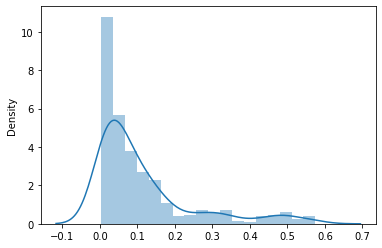

In [ ]:
sns.distplot(drop_df['pred'].values)

Text(0, 0.5, 'True Positive Rate(Positive label: 1)')

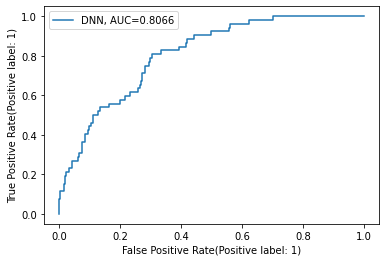

In [ ]:
# Simple Dense Model roc_curve와 SOFA roc_curve 비교하기

from sklearn.metrics import roc_curve, roc_auc_score
real_mean = drop_df['label'].values
pred_mean = drop_df['pred'].values

fpr_sofa, tpr_sofa, thr = roc_curve(real_mean, pred_mean)
sofa_auc = round(roc_auc_score(real_mean, pred_mean), 4)
plt.plot(fpr_sofa, tpr_sofa, label="DNN, AUC="+str(sofa_auc))

plt.legend()
plt.xlabel('False Positive Rate(Positive label: 1)')
plt.ylabel('True Positive Rate(Positive label: 1)')



In [ ]:
abs(fpr_sofa-tpr_sofa)

array([0.        , 0.01923077, 0.07692308, 0.07404951, 0.11251105,
       0.1010168 , 0.13947834, 0.13373121, 0.17219275, 0.16931919,
       0.18854996, 0.17992927, 0.19916004, 0.19053935, 0.20977011,
       0.20689655, 0.22612732, 0.20888594, 0.22811671, 0.22236958,
       0.24160035, 0.23297966, 0.29067197, 0.28205128, 0.32051282,
       0.30901857, 0.32824934, 0.32537577, 0.34460654, 0.33885942,
       0.35809019, 0.35234306, 0.3908046 , 0.37356322, 0.39279399,
       0.3841733 , 0.40340407, 0.37466844, 0.3938992 , 0.35941645,
       0.37864721, 0.36140584, 0.3806366 , 0.36339523, 0.38262599,
       0.35676393, 0.37599469, 0.37024757, 0.38947834, 0.38660477,
       0.40583554, 0.40296198, 0.42219275, 0.41931919, 0.43854996,
       0.42992927, 0.4683908 , 0.45689655, 0.47612732, 0.47038019,
       0.48961096, 0.48386384, 0.50309461, 0.47435897, 0.49358974,
       0.43324492, 0.45247569, 0.42948718, 0.44871795, 0.44584439,
       0.46507515, 0.44208665, 0.46131742, 0.40384615, 0.42307

In [ ]:
thr[(tpr_sofa>0.9) & (fpr_sofa>0.9)]

array([0.00293905])

In [ ]:
cut = 0.2

In [ ]:
drop_df.query('pred>=@cut and label==1').LOS.mean()

12.26923076923077

In [ ]:
drop_df.query('pred<@cut and label==1').LOS.mean()

13.73076923076923

In [ ]:
drop_df[['pred', 'LOS', 'RR', 'Gender', 'label']].corr()

,pred,LOS,RR,Gender,label
pred,1.000000,0.105271,0.146014,-0.006090,0.391872
LOS,0.105271,1.000000,0.131496,-0.003427,-0.015716
RR,0.146014,0.131496,1.000000,0.057288,0.061910
Gender,-0.006090,-0.003427,0.057288,1.000000,0.001504
label,0.391872,-0.015716,0.061910,0.001504,1.000000


In [ ]:
# condition bad -> stay longer

In [ ]:
drop_df.query('pred>@cut and label==0').LOS.mean()

16.473684210526315

In [ ]:
drop_df.query('pred<=@cut and label==0').LOS.mean()

13.203225806451613

In [ ]:
drop_df.columns

Index(['pid', 'age', 'Gender', 'ALP', 'ALT', 'AST', 'Albumin', 'BUN',
       'Bilirubin', 'Cholesterol', 'Creatinine', 'FiO2', 'GCS', 'Glucose',
       'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'Na', 'PaCO2', 'PaO2',
       'Platelets', 'RR', 'SPO2', 'BT', 'TroponinI', 'TroponinT', 'Urine',
       'WBC', 'pH', 'MechVent', 'survival', 'SBP', 'DBP', 'MBP', 'male',
       'female', 'surv_los', 'LOS', 'labels', 'ICUType_1.0', 'ICUType_2.0',
       'ICUType_3.0', 'ICUType_4.0', 'cnn_pred_30', 'label', 'pred'],
      dtype='object')

In [ ]:
drop_df = drop_df.rename(columns = {
    "ICUType_1.0":"ICUType_1",
    "ICUType_2.0": "ICUType_2",
    "ICUType_3.0": "ICUType_3",
    "ICUType_4.0": "ICUType_4"
})

In [ ]:
drop_df["ICUType_1.0`"]

KeyError: ignored

1 0.0    45
1.0     5
Name: label, dtype: int64
2 0.0    80
1.0     6
Name: label, dtype: int64
3 0.0    124
1.0     30
Name: label, dtype: int64
4 0.0    99
1.0    11
Name: label, dtype: int64


Text(0, 0.5, 'True Positive Rate(Positive label: 1)')

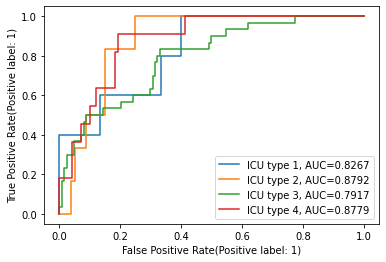

In [ ]:
for i in range(1, 5):
    icu_df = drop_df.query(f"ICUType_{i}==1")
    print(i, icu_df.label.value_counts())
    # Simple Dense Model roc_curve와 SOFA roc_curve 비교하기

    real_mean = icu_df['label'].values
    pred_mean = icu_df['pred'].values

    fpr_sofa, tpr_sofa, thr = roc_curve(real_mean, pred_mean)
    sofa_auc = round(roc_auc_score(real_mean, pred_mean), 4)
    plt.plot(fpr_sofa, tpr_sofa, label=f"ICU type {i}, AUC="+str(sofa_auc))

plt.legend()
plt.xlabel('False Positive Rate(Positive label: 1)')
plt.ylabel('True Positive Rate(Positive label: 1)')



In [ ]:
# ICUType (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit,
# 3: Medical ICU, or 4: Surgical ICU)

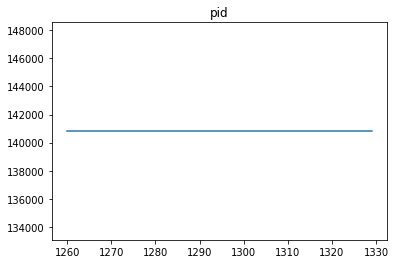

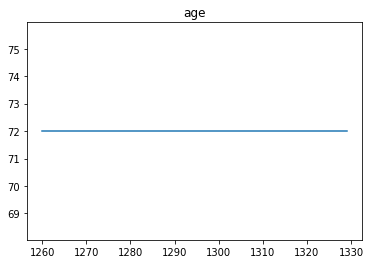

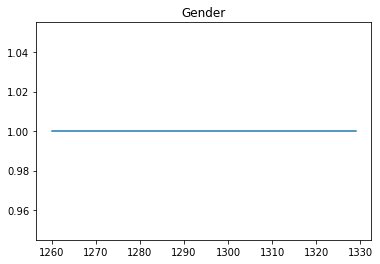

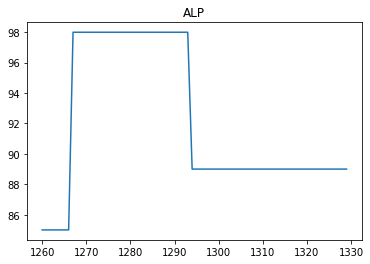

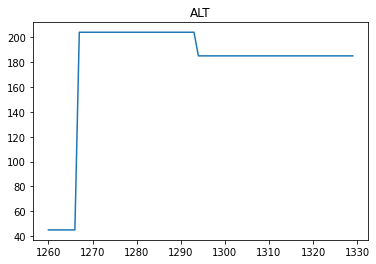

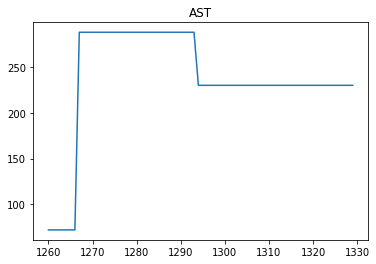

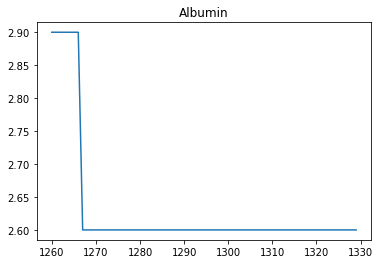

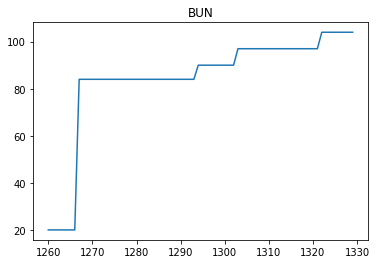

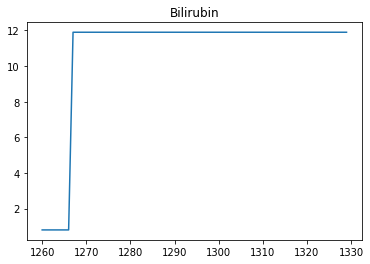

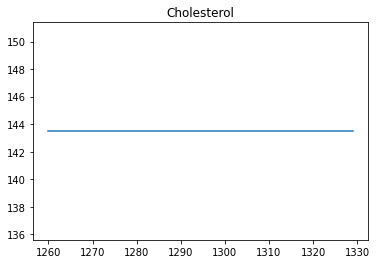

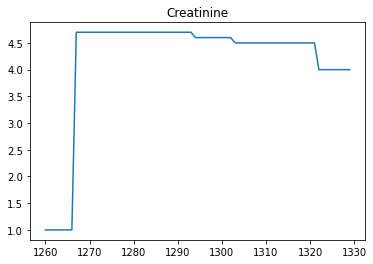

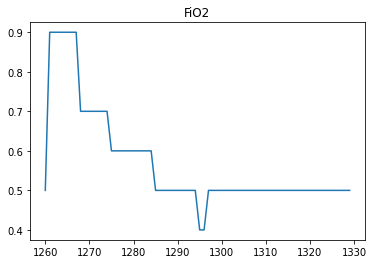

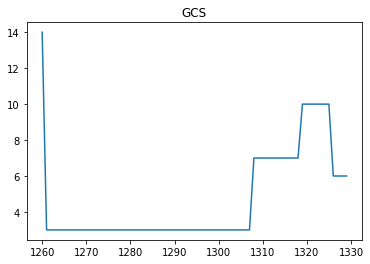

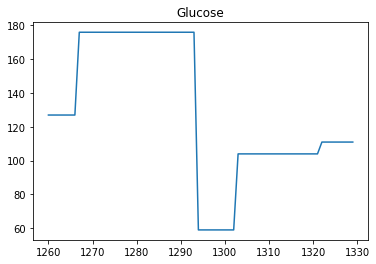

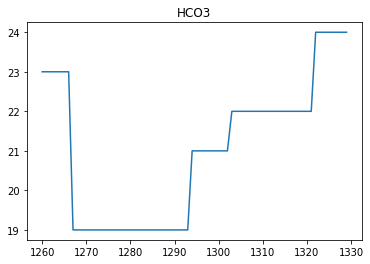

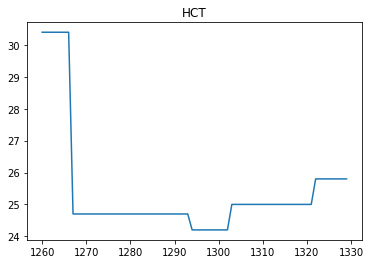

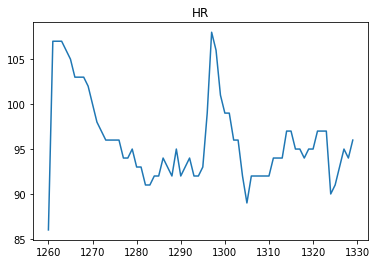

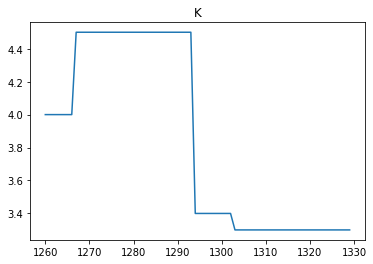

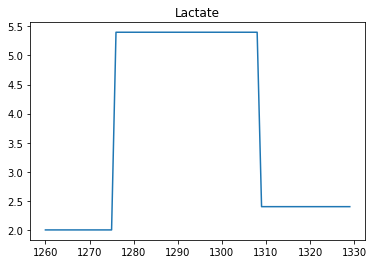

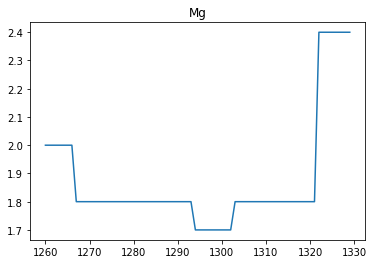

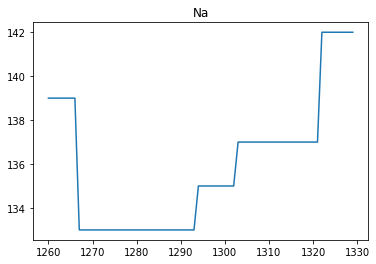

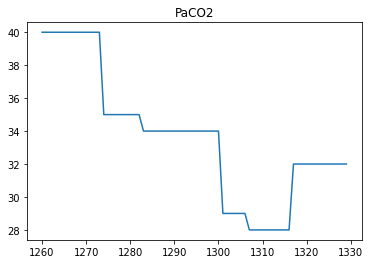

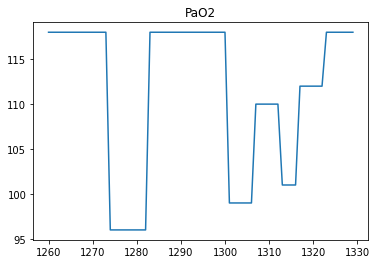

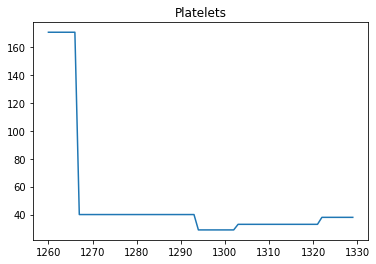

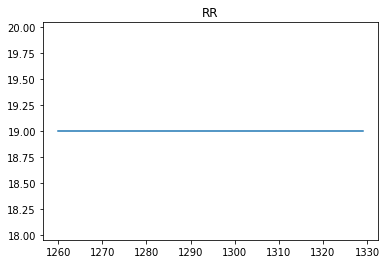

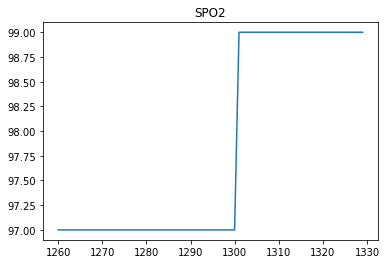

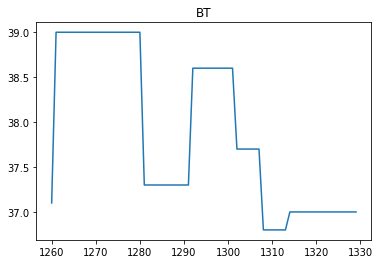

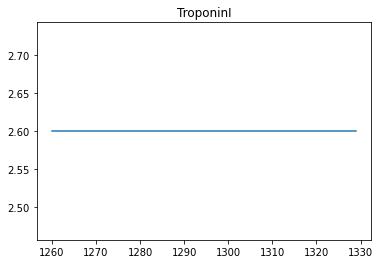

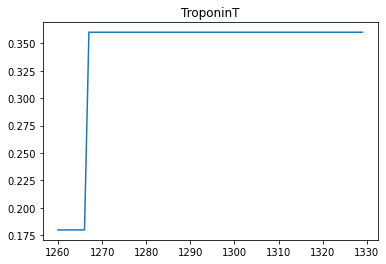

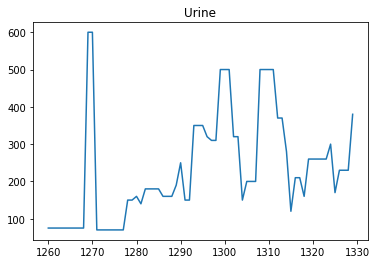

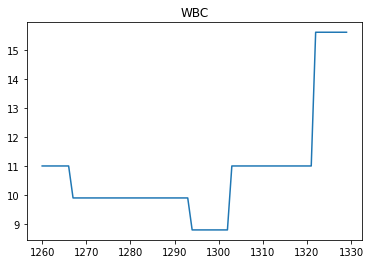

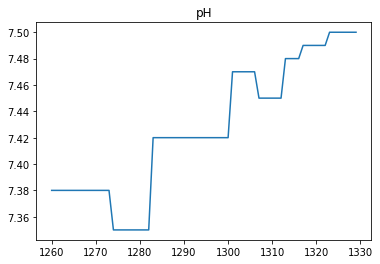

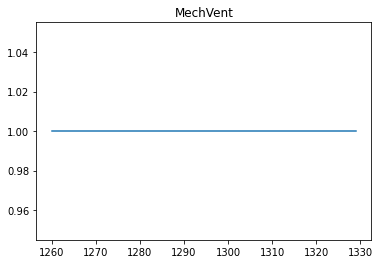

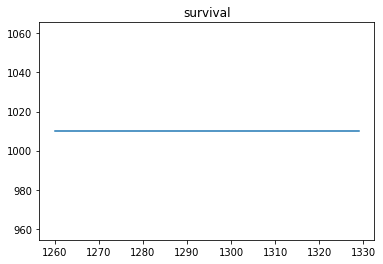

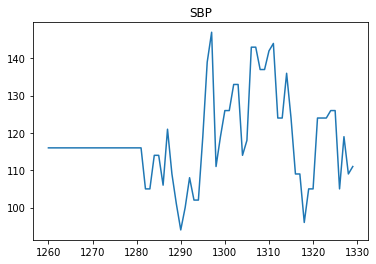

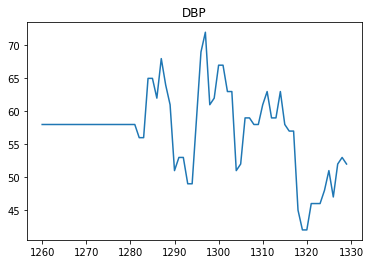

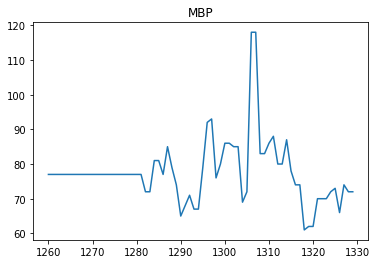

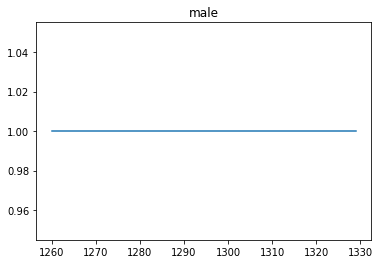

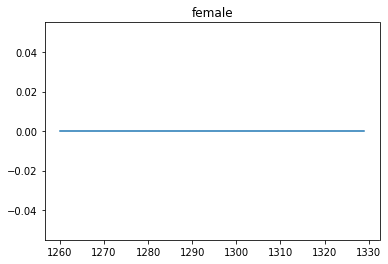

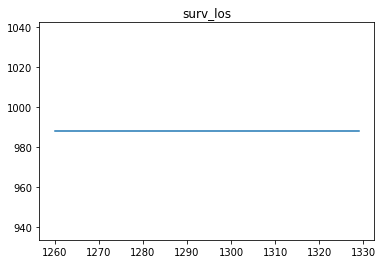

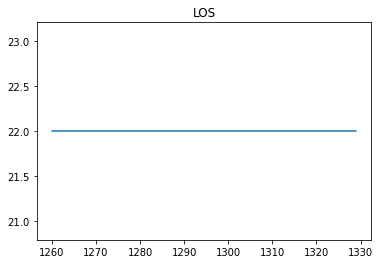

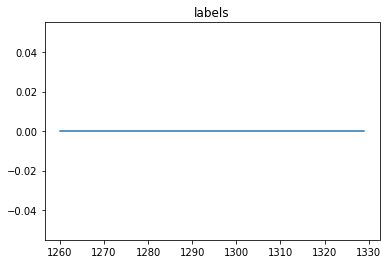

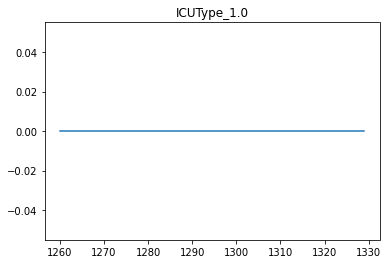

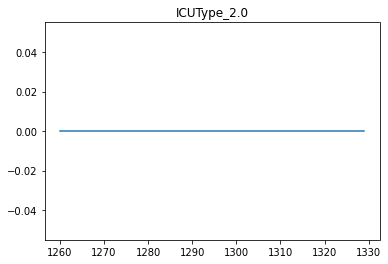

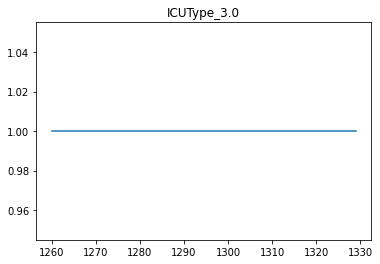

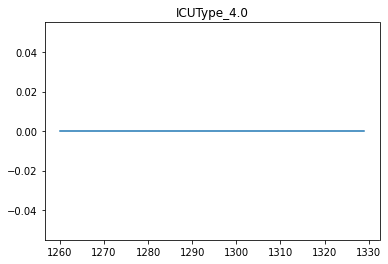

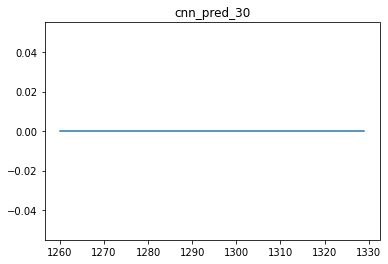

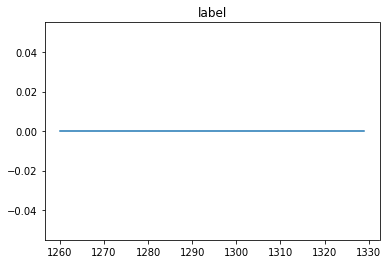

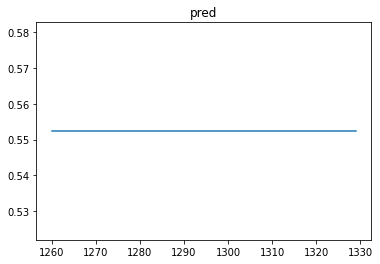

In [ ]:
for col in test_df.columns:
    plt.title(col)
    plt.plot(test_df.query('pid==140821.0')[col])
#    plt.plot(test_df[col].mean())
    plt.show()